<a href="https://colab.research.google.com/github/Priyesh17/melanoma-detection-cnn/blob/main/priyesh_raj_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports goes here.

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
# load GDrive

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!ls '/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip'

/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip


In [5]:
# Unzip the dataset
!unzip '/content/gdrive/MyDrive/Upgrad/CNN_assignment.zip' > /dev/null

In [6]:
!ls '/content/'

 gdrive       'Skin cancer ISIC The International Skin Imaging Collaboration'
 sample_data


In [7]:
# Test and Train data.

data_dir_train = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/")
data_dir_test = pathlib.Path("/content/Skin cancer ISIC The International Skin Imaging Collaboration/Test/")

In [8]:
# Count
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


# Dataset creation

**Create a dataset**

In [9]:
batch_size = 32
img_height = 180
img_width = 180

In [10]:
# As per instruction, 80% is used for training and 20% for validation

# train set
train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="training",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [11]:
#Validation Dataset
val_ds =tf.keras.preprocessing.image_dataset_from_directory(data_dir_train,batch_size=batch_size,image_size=(img_height,img_width),label_mode='categorical',
                                                              seed=123,subset="validation",validation_split=0.2)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


# Visualize the data

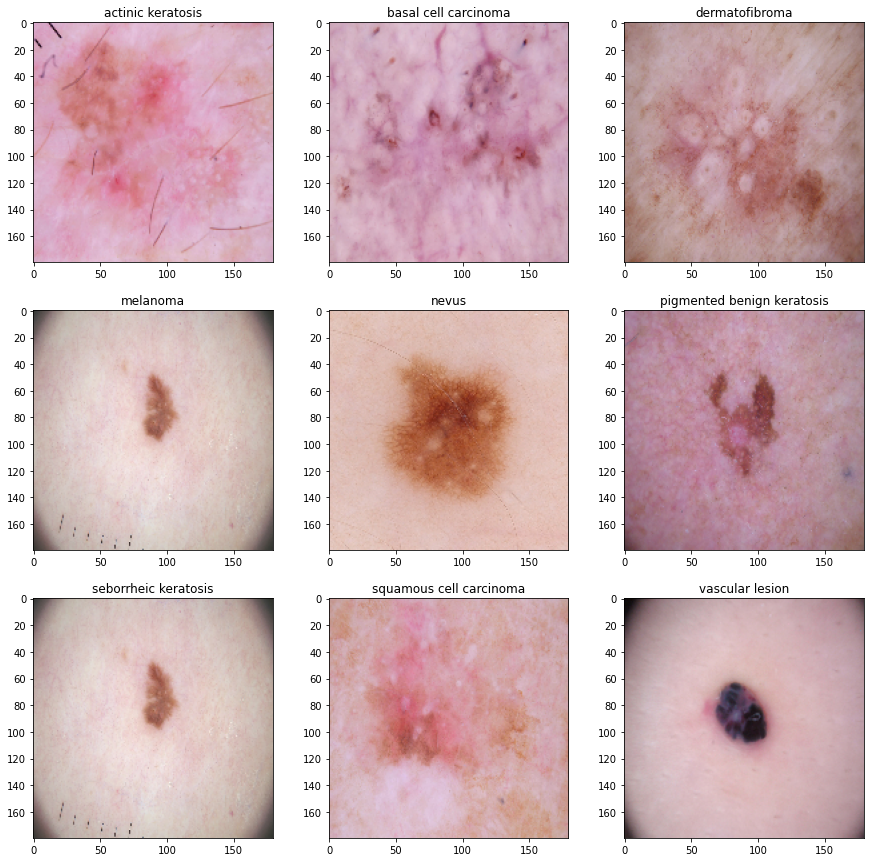

In [13]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

#Dictionary to store the path of image as per the class
files_path_dict = {}

for c in class_names:
    files_path_dict[c] = list(map(lambda x:str(data_dir_train)+'/'+c+'/'+x,os.listdir(str(data_dir_train)+'/'+c)))
    
#Visualize image 
plt.figure(figsize=(15,15))
index = 0
for c in class_names:
    path_list = files_path_dict[c][:1]
    index += 1
    plt.subplot(3,3,index)
    plt.imshow(load_img(path_list[0],target_size=(img_height,img_width)))
    plt.title(c)

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [14]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 1

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [15]:
input_shape = (img_height,img_width,3)

model = Sequential()    #Sequential allows you to create models layer-by-layer  

#First Convulation Layer
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=input_shape))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Second Convulation Layer
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

#Third Convulation Layer
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))

model.add(layers.Flatten())   #Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.

#Dense Layer
model.add(layers.Dense(512,activation='relu'))

#Dense Layer
model.add(layers.Dense(128,activation='relu'))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [16]:
model.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [17]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 89, 89, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 43, 43, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 41, 41, 128)       7

### Train the model

In [18]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 23s 69ms/step - loss: 2.0219 - accuracy: 0.2645 - val_loss: 1.7333 - val_accuracy: 0.3423
Epoch 2/20
56/56 [==============================] - 1s 26ms/step - loss: 1.6257 - accuracy: 0.4230 - val_loss: 1.6417 - val_accuracy: 0.4609
Epoch 3/20
56/56 [==============================] - 1s 26ms/step - loss: 1.4635 - accuracy: 0.4760 - val_loss: 1.4278 - val_accuracy: 0.5078
Epoch 4/20
56/56 [==============================] - 1s 26ms/step - loss: 1.3314 - accuracy: 0.5307 - val_loss: 1.3862 - val_accuracy: 0.5101
Epoch 5/20
56/56 [==============================] - 1s 26ms/step - loss: 1.2816 - accuracy: 0.5502 - val_loss: 1.4671 - val_accuracy: 0.4474
Epoch 6/20
56/56 [==============================] - 1s 26ms/step - loss: 1.2619 - accuracy: 0.5419 - val_loss: 1.4931 - val_accuracy: 0.4787
Epoch 7/20
56/56 [==============================] - 1s 26ms/step - loss: 1.1591 - accuracy: 0.5971 - val_loss: 1.4675 - val_accuracy: 0.5213
Epoch 8/20
5

### Visualizing the results

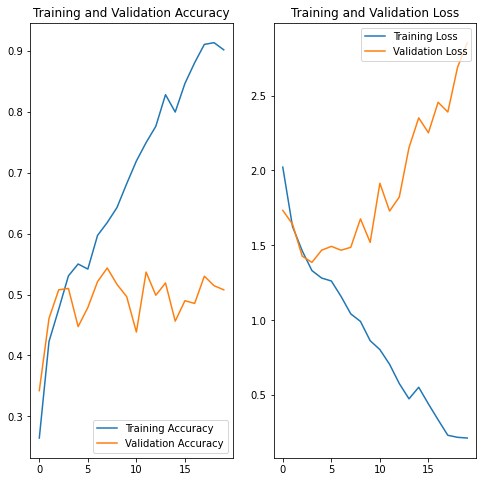

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Validate the model

In [20]:
# Model fitting.

loss, accuracy = model.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 11ms/step - loss: 2.8526 - accuracy: 0.5078
Accuracy:  0.9358258843421936
Validation Accuracy:  0.5078299641609192
Loss:  0.1320151686668396
Validation Loss 2.8526206016540527


On train data, model shows 86% accouracy, which goes down to 50% on validation set. This shows that the model has overfitted. We need some kind of augmentation to fix this issue.

In [21]:
# Data augumentation strategy. 
# Let's rescale the image.

rescale = tf.keras.Sequential([
  #To rescale an input in the [0, 255] range to be in the [0, 1] range  
  layers.experimental.preprocessing.Rescaling(1./255)
])

data_augmentation = tf.keras.Sequential([
  #Randomly flip each image horizontally and vertically.
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    
  #Randomly rotate each image.
  layers.experimental.preprocessing.RandomRotation(0.2),
    
  #Randomly zoom each image during training.
  layers.experimental.preprocessing.RandomZoom(0.2),
    
  #Randomly translate each image during training.
  layers.experimental.preprocessing.RandomTranslation(0.1, 0.1)    
])

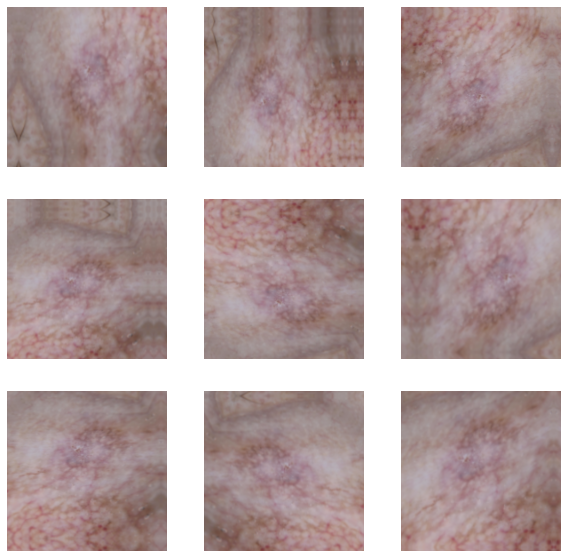

In [22]:
# Visualize the augmentation image
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):   
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

# Model 2:

### Create the model, compile and train the model

In [23]:
model2 = Sequential()                     #Sequential allows you to create models layer-by-layer  

model2.add(data_augmentation)             #Augmentation layer
model2.add(rescale)                       #Rescaling layer

#First Convulation Layer
model2.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Second Convulation Layer
model2.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Dropout layer with 25% Fraction of the input units to drop.
model2.add(layers.Dropout(0.25))

#Third Convulation Layer
model2.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model2.add(layers.MaxPool2D(pool_size=(2,2)))

#Keras.layers.flatten function flattens the multi-dimensional input tensors into a single dimension.
model2.add(layers.Flatten())

#Dense Layer
model2.add(layers.Dense(512,activation='relu'))

#Dense Layer
model2.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model2.add(layers.Dropout(0.50))

#Dense Layer with softmax activation function.
#Softmax is an activation function that scales numbers/logits into probabilities.
model2.add(layers.Dense(len(class_names),activation='softmax'))

### Compiling the model

In [24]:
model2.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Training the model

In [25]:
epochs =20
history = model2.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/20
56/56 [==============================] - 4s 35ms/step - loss: 2.6002 - accuracy: 0.1713 - val_loss: 2.0965 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 2s 32ms/step - loss: 2.0437 - accuracy: 0.2126 - val_loss: 2.0420 - val_accuracy: 0.2685
Epoch 3/20
56/56 [==============================] - 2s 32ms/step - loss: 1.9870 - accuracy: 0.2600 - val_loss: 1.9339 - val_accuracy: 0.3043
Epoch 4/20
56/56 [==============================] - 2s 32ms/step - loss: 1.8464 - accuracy: 0.3259 - val_loss: 1.8405 - val_accuracy: 0.3982
Epoch 5/20
56/56 [==============================] - 2s 32ms/step - loss: 1.7551 - accuracy: 0.3811 - val_loss: 1.7282 - val_accuracy: 0.4094
Epoch 6/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6805 - accuracy: 0.3951 - val_loss: 1.5705 - val_accuracy: 0.4653
Epoch 7/20
56/56 [==============================] - 2s 32ms/step - loss: 1.6835 - accuracy: 0.4062 - val_loss: 1.7229 - val_accuracy: 0.4228
Epoch 8/20
56

### Visualizing the results

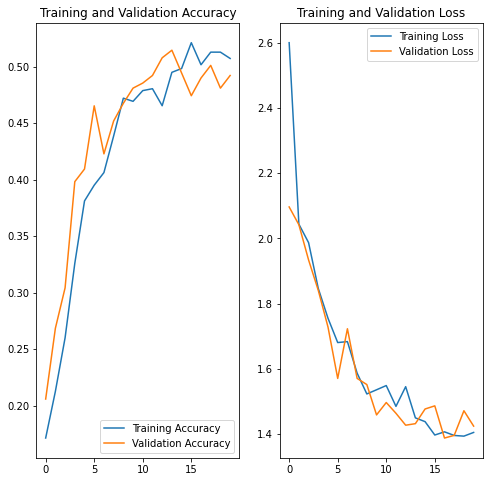

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Validate the model

In [27]:
loss, accuracy = model2.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model2.evaluate(val_ds, verbose=1)

print("Accuracy: ", accuracy)
print("Validation Accuracy: ",accuracy_v)
print("Loss: ",loss)
print("Validation Loss", loss_v)

14/14 [==============================] - 0s 11ms/step - loss: 1.4243 - accuracy: 0.4922
Accuracy:  0.484375
Validation Accuracy:  0.4921700358390808
Loss:  1.396406888961792
Validation Loss 1.4242687225341797


After re-scaling the image, the accuracy of model has gone 
down, but now accuracy and validation accuracy are almost similar, which means we have solved the problem of overfitting.

We need to check for class imbalance to see how to increase the accuracy of the model.


In [28]:
def count_distribution(directory):
    
    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))
    
    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]
    
    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = count_distribution(data_dir_train)
df

,Class,No. of Image
0,actinic keratosis,114
1,melanoma,438
2,dermatofibroma,95
3,squamous cell carcinoma,181
4,basal cell carcinoma,376
5,vascular lesion,139
6,pigmented benign keratosis,462
7,seborrheic keratosis,77
8,nevus,357




*   seborrheic keratosis has least number of images - 77
*   Pigmented benign ketosis dominates the image number with 462
*   Pigmented benign ketosis, melanoma, basal cell carcinoma and nevus dominates the class distribution.





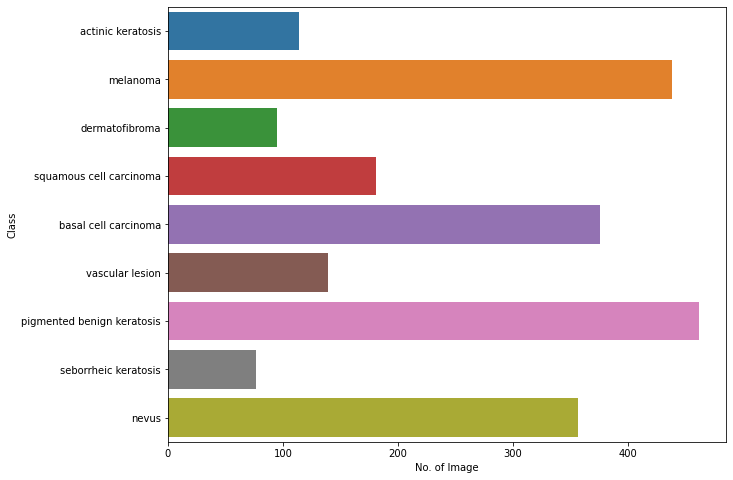

In [29]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df,
            label="Class")

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

# Rectify imbalance with augmentor.

### Install Augmentor

In [30]:
!pip install Augmentor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


### Create augmented images

In [31]:
path_to_training_dataset="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40F242AED0>: 100%|██████████| 500/500 [00:18<00:00, 27.65 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40CFDDF890>: 100%|██████████| 500/500 [00:18<00:00, 26.42 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F40CFDDDB50>: 100%|██████████| 500/500 [00:20<00:00, 24.82 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=3072x2304 at 0x7F40F238A690>: 100%|██████████| 500/500 [01:24<00:00,  5.93 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7F40F24EEBD0>: 100%|██████████| 500/500 [01:28<00:00,  5.65 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7F40F4284F50>: 100%|██████████| 500/500 [00:18<00:00, 26.65 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7F41FC7C5E10>: 100%|██████████| 500/500 [00:39<00:00, 12.81 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F41700B9E50>: 100%|██████████| 500/500 [00:16<00:00, 31.07 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7F40F4163810>: 100%|██████████| 500/500 [00:16<00:00, 29.84 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [32]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Check distribution of augmented data

In [33]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0031430.jpg_5539afc8-59a9-44ca-ad39-ac395fc19dc3.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026457.jpg_03880c9e-6486-4fd6-97b6-22c2f7230ab5.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0027884.jpg_f42eb6ce-9084-4cd7-980f-e9857a80a1f6.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0026040.jpg_9e9d120f-d458-484f-acef-a66af3cfe511.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output/actinic keratosis_original_ISIC_0028190.jpg_56f2c123-0da5-4933-aa8a-02a41f3c082e.jpg',
 '/content/Skin cancer ISIC The International

In [34]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic keratosis',
 'actinic 

In [35]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [36]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])

In [37]:
#label count.
df2['Label'].value_counts()

actinic keratosis             500
melanoma                      500
dermatofibroma                500
squamous cell carcinoma       500
basal cell carcinoma          500
vascular lesion               500
pigmented benign keratosis    500
seborrheic keratosis          500
nevus                         500
Name: Label, dtype: int64

# Train the model on the data created using Augmentor

In [38]:
batch_size = 32
img_height = 180
img_width = 180

### Create a training dataset

In [39]:
data_dir_train="/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/" 

#Training dataset.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,    #20% fraction of data to reserve for validation.
  subset = "training",
  image_size=(img_height, img_width),label_mode='categorical',  #label_mode='categorical' means that the labels are encoded as a categorical vector 
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


### Create a validation dataset

In [40]:
#Validation dataset.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = "validation",
  image_size=(img_height, img_width),label_mode='categorical',   #label_mode='categorical' means that the labels are encoded as a categorical vector
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


### Create Model

In [41]:
model3 = Sequential()

model3.add(rescale)   #Rescaling Layer

#First Convulation layer
model3.add(layers.Conv2D(32,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Second Convulation Layer
model3.add(layers.Conv2D(64,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))
model3.add(layers.Dropout(0.25))

#Third Convulation Layer
model3.add(layers.Conv2D(128,kernel_size=(2,2),activation='relu'))
model3.add(layers.MaxPool2D(pool_size=(2,2)))

#Flatten Layer
model3.add(layers.Flatten())

#Dense Layer
model3.add(layers.Dense(512,activation='relu'))

#Dropout layer
model3.add(layers.Dropout(0.25))

#Batch normalization: is a method used to make artificial neural networks faster and more stable through normalization 
#of the layers' inputs by re-centering and re-scaling.
model3.add(layers.BatchNormalization())

#Dense Layer
model3.add(layers.Dense(128,activation='relu'))

#Dropout layer with 50% Fraction of the input units to drop.
model3.add(layers.Dropout(0.50))

#Batch normalization
model3.add(layers.BatchNormalization())

#Dense layer with Softmax activation function.
model3.add(layers.Dense(len(class_names),activation='softmax'))

### Compile the model

In [42]:
model3.compile(optimizer='Adam',
              loss="categorical_crossentropy",
              metrics=['accuracy'])

### Train the model

In [ ]:
epochs = 50
history = model3.fit(train_ds,epochs=epochs,validation_data=val_ds,verbose=1)

Epoch 1/50
169/169 [==============================] - 33s 183ms/step - loss: 2.4922 - accuracy: 0.1834 - val_loss: 4.6168 - val_accuracy: 0.1359
Epoch 2/50
169/169 [==============================] - 23s 130ms/step - loss: 1.8991 - accuracy: 0.3056 - val_loss: 3.2114 - val_accuracy: 0.1826
Epoch 3/50
169/169 [==============================] - 23s 130ms/step - loss: 1.6126 - accuracy: 0.3932 - val_loss: 1.8114 - val_accuracy: 0.3200
Epoch 4/50
169/169 [==============================] - 24s 138ms/step - loss: 1.4849 - accuracy: 0.4353 - val_loss: 1.6245 - val_accuracy: 0.3719
Epoch 5/50
169/169 [==============================] - 23s 130ms/step - loss: 1.4138 - accuracy: 0.4688 - val_loss: 1.4908 - val_accuracy: 0.4105
Epoch 6/50
169/169 [==============================] - 23s 131ms/step - loss: 1.3466 - accuracy: 0.4902 - val_loss: 1.7885 - val_accuracy: 0.3653
Epoch 7/50
169/169 [==============================] - 23s 130ms/step - loss: 1.2772 - accuracy: 0.5208 - val_loss: 1.6651 - val_ac

### Visualise the results

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

As per the final model (model3) Training accuracy and validation accuracy increases.
Model overfitting issue is solved.
Class rebalance helps in augmentation and achieving the best Training and validation accuracy.